##**Name-Himasish Ghosal , Roll No-MA24M010**

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ---------------------------
# 1. Model and Data
# ---------------------------

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 128), nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root="./data", train=True,
                               download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False,
                              download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

criterion = nn.CrossEntropyLoss()

Using device: cuda


In [10]:
# ---------------------------
# 2. Flatten / set parameters
# ---------------------------

def flatten_params(model):
    return torch.cat([p.detach().reshape(-1) for p in model.parameters()])

def set_params(model, flat):
    idx = 0
    for p in model.parameters():
        n = p.numel()
        p.data.copy_(flat[idx:idx+n].view_as(p))
        idx += n

def param_shapes(model):
    return [p.shape for p in model.parameters()]

In [11]:
# ---------------------------
# 3. Filter-normalized directions
# ---------------------------

def normalize_direction(model, direction, eps=1e-10):
    out = []
    idx = 0
    for p in model.parameters():
        n = p.numel()
        d = direction[idx:idx+n].view_as(p)
        scale = p.norm() / (d.norm() + eps)
        d = d * scale
        out.append(d.view(-1))
        idx += n
    return torch.cat(out)

def random_direction(model):
    d = torch.randn_like(flatten_params(model))
    return normalize_direction(model, d)

In [12]:
# ---------------------------
# 4. Training with snapshots
# ---------------------------

def train_with_snapshots(epochs=3, snapshot_every=100):
    model = SimpleCNN().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

    loss_history = []
    gradnorm_history = []
    snapshots = []

    step = 0
    for epoch in range(epochs):
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()

            # gradient norm
            total_norm = torch.norm(torch.stack([
                p.grad.detach().norm() for p in model.parameters()
                if p.grad is not None
            ]))
            gradnorm_history.append(total_norm.item())

            optimizer.step()
            loss_history.append(loss.item())

            if step % snapshot_every == 0:
                snapshots.append(flatten_params(model).cpu().numpy())
            step += 1

        print(f"Epoch {epoch+1}/{epochs}, loss={loss.item():.4f}")

    snapshots = np.array(snapshots)
    return model, np.array(loss_history), np.array(gradnorm_history), snapshots

model, loss_hist, grad_hist, snapshots = train_with_snapshots()

# one small batch used later for probing
batch_x, batch_y = next(iter(train_loader))
batch_x, batch_y = batch_x.to(device), batch_y.to(device)

Epoch 1/3, loss=0.0509
Epoch 2/3, loss=0.0282
Epoch 3/3, loss=0.0055


In [13]:

# ---------------------------
# 5. Hessian top eigenvalue
# ---------------------------

def hessian_top_eigenvalue(model, x, y, iters=20):
    model.zero_grad()
    params_flat = flatten_params(model)
    v = torch.randn_like(params_flat)
    v = v / v.norm()

    for _ in range(iters):
        model.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
        g_flat = torch.cat([g.reshape(-1) for g in grads])

        Hv = torch.autograd.grad(g_flat, model.parameters(),
                                 grad_outputs=v, retain_graph=True)
        Hv_flat = torch.cat([h.reshape(-1) for h in Hv])

        v = Hv_flat / Hv_flat.norm()

    # Rayleigh quotient
    model.zero_grad()
    out = model(x)
    loss = criterion(out, y)
    grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    g_flat = torch.cat([g.reshape(-1) for g in grads])
    Hv = torch.autograd.grad(g_flat, model.parameters(),
                             grad_outputs=v, retain_graph=True)
    Hv_flat = torch.cat([h.reshape(-1) for h in Hv])
    eigval = torch.dot(v, Hv_flat).item()
    return eigval

eig = hessian_top_eigenvalue(model, batch_x, batch_y, iters=15)
print("Estimated top Hessian eigenvalue:", eig)

Estimated top Hessian eigenvalue: 1.6376839876174927


In [14]:
# ---------------------------
# 6. Loss evaluation helpers
# ---------------------------

def loss_at_params(model, params_flat, x, y):
    old = flatten_params(model).clone()
    set_params(model, params_flat)
    with torch.no_grad():
        out = model(x)
        val = criterion(out, y).item()
    set_params(model, old)
    return val

w0 = flatten_params(model)

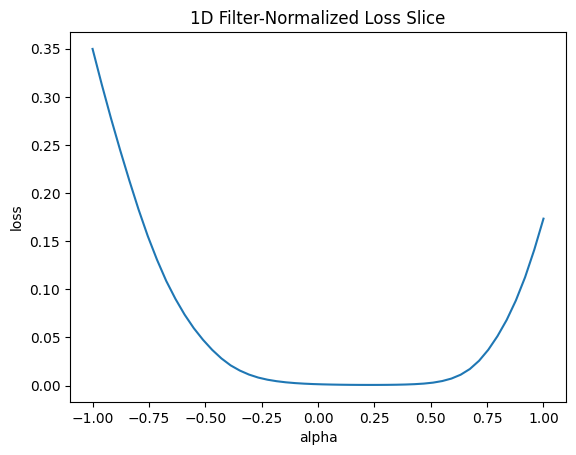

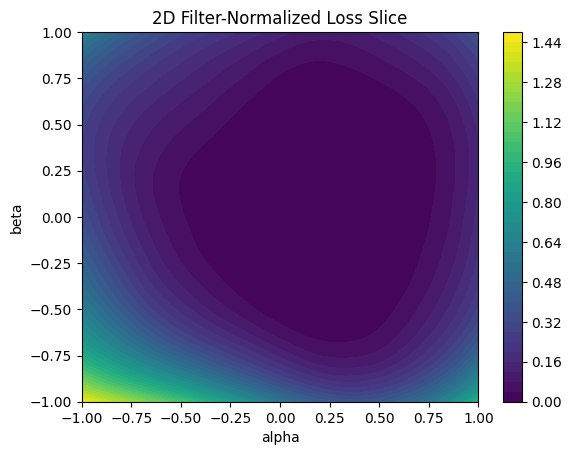

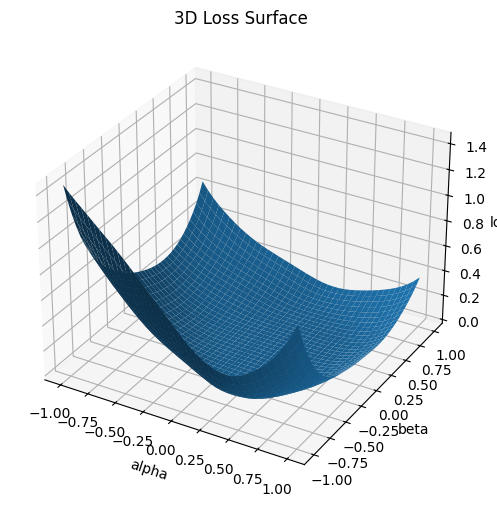

In [15]:
#---------------------------
# 7. 1D and 2D landscape (random directions)
# ---------------------------

def plot_1d_landscape(model, w0, direction, x, y,
                      alpha_min=-1.0, alpha_max=1.0, steps=50):
    alphas = np.linspace(alpha_min, alpha_max, steps)
    losses = []
    for a in alphas:
        w = w0 + a * direction
        losses.append(loss_at_params(model, w, x, y))
    plt.figure()
    plt.plot(alphas, losses)
    plt.xlabel("alpha")
    plt.ylabel("loss")
    plt.title("1D Filter-Normalized Loss Slice")
    plt.show()

def plot_2d_landscape(model, w0, d1, d2, x, y,
                      grid=40, alpha_range=(-1,1), beta_range=(-1,1)):
    alphas = np.linspace(alpha_range[0], alpha_range[1], grid)
    betas  = np.linspace(beta_range[0], beta_range[1], grid)
    A, B = np.meshgrid(alphas, betas)
    Z = np.zeros_like(A)

    for i in range(grid):
        for j in range(grid):
            w = w0 + A[i,j] * d1 + B[i,j] * d2
            Z[i,j] = loss_at_params(model, w, x, y)

    plt.figure()
    cs = plt.contourf(A, B, Z, levels=40)
    plt.colorbar(cs)
    plt.xlabel("alpha")
    plt.ylabel("beta")
    plt.title("2D Filter-Normalized Loss Slice")
    plt.show()

    # 3D surface
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(A, B, Z, linewidth=0, antialiased=True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("beta")
    ax.set_zlabel("loss")
    ax.set_title("3D Loss Surface")
    plt.show()

d1 = random_direction(model)
d2 = random_direction(model)

plot_1d_landscape(model, w0, d1, batch_x, batch_y)
plot_2d_landscape(model, w0, d1, d2, batch_x, batch_y)


Top singular values (trajectory variance): [13.203605   6.0118575  3.353912   2.3469362  2.0776243]


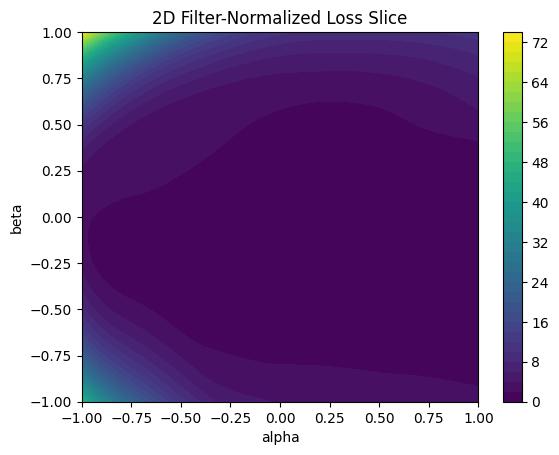

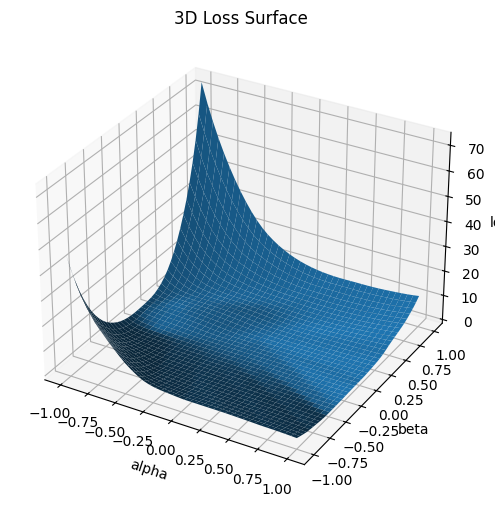

In [16]:
# ---------------------------
# 8. PCA-based directions from SGD snapshots
# ---------------------------

def pca_directions(snapshots, k=2):
    X = snapshots - snapshots.mean(axis=0, keepdims=True)
    # economy SVD
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    pcs = Vt[:k]   # shape (k, D)
    pcs_torch = [torch.tensor(pc, device=device).float() for pc in pcs]
    return pcs_torch, S

pcs, Svals = pca_directions(snapshots, k=2)
print("Top singular values (trajectory variance):", Svals[:5])

# Use PCA directions (also filter-normalized)
pc1 = normalize_direction(model, pcs[0])
pc2 = normalize_direction(model, pcs[1])
plot_2d_landscape(model, w0, pc1, pc2, batch_x, batch_y)

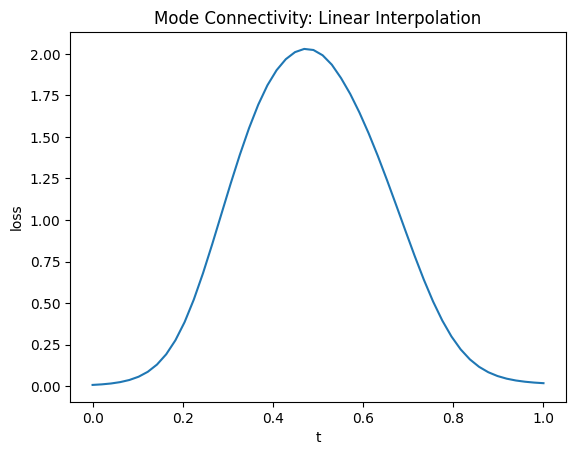

In [17]:

# ---------------------------
# 9. Mode connectivity between two independent minima
# ---------------------------

def train_simple_cnn():
    m = SimpleCNN().to(device)
    opt = optim.SGD(m.parameters(), lr=0.05, momentum=0.9)
    for epoch in range(2):  # few epochs for demo
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            out = m(x)
            loss = criterion(out, y)
            loss.backward()
            opt.step()
    return m

modelA = train_simple_cnn()
modelB = train_simple_cnn()

wA = flatten_params(modelA)
wB = flatten_params(modelB)

def plot_mode_connectivity(model_ref, wA, wB, x, y, points=50):
    ts = np.linspace(0,1,points)
    losses = []
    for t in ts:
        w = (1-t) * wA + t * wB
        losses.append(loss_at_params(model_ref, w, x, y))
    plt.figure()
    plt.plot(ts, losses)
    plt.xlabel("t")
    plt.ylabel("loss")
    plt.title("Mode Connectivity: Linear Interpolation")
    plt.show()

# use the main model as reference for evaluation graph
plot_mode_connectivity(model, wA, wB, batch_x, batch_y)

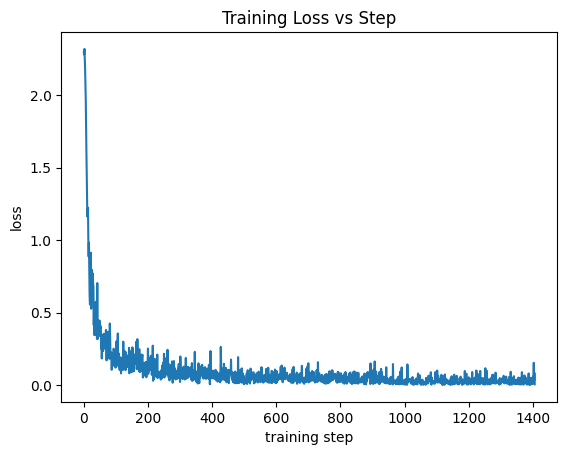

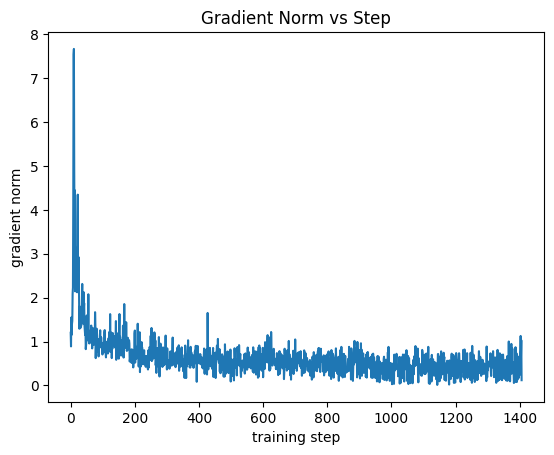

In [18]:
# ---------------------------
# 10. Plot optimization dynamics
# ---------------------------

plt.figure()
plt.plot(loss_hist)
plt.xlabel("training step")
plt.ylabel("loss")
plt.title("Training Loss vs Step")
plt.show()

plt.figure()
plt.plot(grad_hist)
plt.xlabel("training step")
plt.ylabel("gradient norm")
plt.title("Gradient Norm vs Step")
plt.show()